In [1]:
from src.esn import ESN
from src.utils import config, helper
from src.conceptors import compute_conceptor, loading_ridge_report, compute_conceptor_diag, ridge_regression

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Classical Conceptor

## Initialization

In [3]:
prng = np.random.default_rng(1234)

In [4]:
esnConfig = config.ESNConfig(
    input_size=1,
    reservoir_size=100,
    output_size=1,
    feedback=False,
    spectral_radius=1,
    init_weights='normal',
    init_weights_b='normal',
    init_weights_in='normal',
    init_weights_density=0.1,
    init_weights_in_density=1.0,
    init_weights__args={'loc': 0., 'scale': 1.},
    init_weights_b__args={'loc': 0., 'scale': 0.2},
    init_weights_in__args={'loc': 0., 'scale': 1.},
)

In [5]:
T_pattern = 2500
ut = [
    helper.n_periodic(5, T_pattern, np.random.default_rng(27)),
    helper.n_periodic(5, T_pattern, np.random.default_rng(42)),
    helper.n_sine(8.83, T_pattern, phase=0.),
    helper.n_sine(9.83, T_pattern, phase=0.)
]

In [6]:
T_WASHOUT = 200
LOADING_REGULARIZER = 1e-3
APERTURE = 100

In [7]:
esn = ESN(esnConfig, prng)

## Loading and training of readout

In [8]:
xt, yt = list(zip(*map(esn.harvest_states, ut)))
# concatenate patterns along time
X = helper.concatenate_patterns(xt, T_WASHOUT)
U = helper.concatenate_patterns(ut, T_WASHOUT)

In [9]:
Y_T = U.copy()
w_before_training = esn.w
esn.update_weights(X, U, Y_T, alpha=1e-3)

In [10]:
esn.w.shape

(100, 100)

In [ ]:
_, yt_trained = list(zip(*map(esn.harvest_states, ut)))

### 

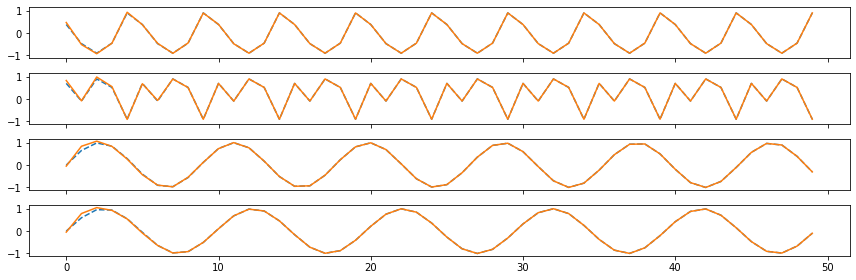

In [12]:
fig, ax = plt.subplots(len(ut), 1, figsize=(12, len(ut)), sharex=True, sharey=True)
for i in range(len(ut)):
    ax[i].plot(ut[i][:50], ls='--')
    ax[i].plot(yt_trained[i][:50])
plt.tight_layout()

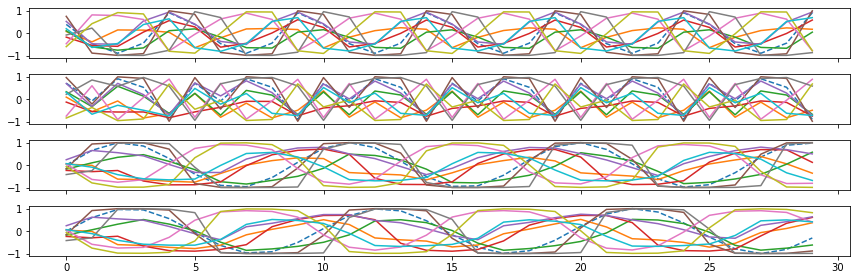

In [13]:
fig, ax = plt.subplots(len(ut), 1, figsize=(12, len(ut)), sharex=True, sharey=True)
for i in range(len(ut)):
    ax[i].plot(ut[i][:30], ls='--')
    ax[i].plot(_[i][:30][:,1:10])
plt.tight_layout()

In [14]:
X_ = helper.concatenate_patterns(xt, T_WASHOUT, shift=-1)
B = np.repeat(esn.b, X_.shape[0], axis=1).T

In [15]:
# Different loading methods
"""
# Arctanh method of loading (cf. eq 115 Jaeger (2017)): 
W_loaded = loading_ridge_report(X, X_, B, regularizer=LOADING_REGULARIZER)
w_before_loading = esn.w.copy()
esn.w = W_loaded.copy()
"""

# Method of loading input explicitely (cf. eq 4 Jaeger (2017))
W_loaded = ridge_regression(X_, (np.dot(esn.w, X_.T) + np.dot(esn.w_in, U.T)).T, regularizer=LOADING_REGULARIZER)
w_before_loading = esn.w.copy()
esn.w = W_loaded.copy()

"""
# Method of loading input explicitely in a dedicated memory matrix (cf. eq 41 Jaeger (2017))
W_loaded = ridge_regression(X_, np.dot(esn.w_in, U.T).T, regularizer=LOADING_REGULARIZER)
w_before_loading = esn.w.copy()
esn.w = W_loaded.copy()+w_before_loading.copy()
"""

'\n# Method of loading input explicitely in a dedicated memory matrix (cf. eq 41 Jaeger (2017))\nW_loaded = ridge_regression(X_, np.dot(esn.w_in, U.T).T, regularizer=LOADING_REGULARIZER)\nw_before_loading = esn.w.copy()\nesn.w = W_loaded.copy()+w_before_loading.copy()\n'

In [16]:
Ci = [
    compute_conceptor(xt_i[T_WASHOUT:, :], aperture=APERTURE)
    for xt_i in xt
]

In [17]:
ut_zero = np.zeros_like(ut[0])
x_init = prng.uniform(low=-1., high=1., size=(esn.reservoir_size, 1))
xt_conceptor, yt_conceptor = list(zip(*[
    esn.harvest_states(ut_zero.copy(), x_init=x_init.copy(), C=Ci[i])
    for i in range(len(ut))
]))

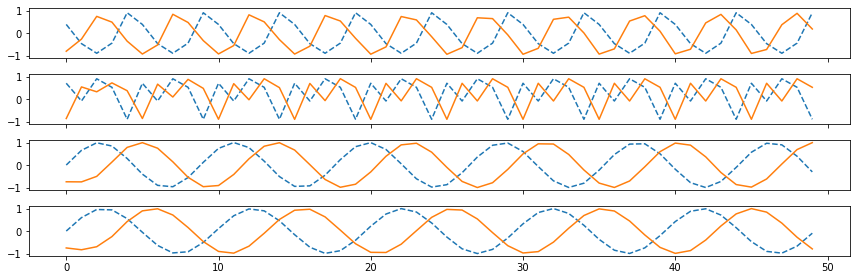

In [18]:
fig, ax = plt.subplots(len(ut), 1, figsize=(12, len(ut)), sharex=True, sharey=True)
for i in range(len(ut)):
    ax[i].plot(ut[i][:50], ls='--')
    ax[i].plot(yt_conceptor[i][:50])
plt.tight_layout()

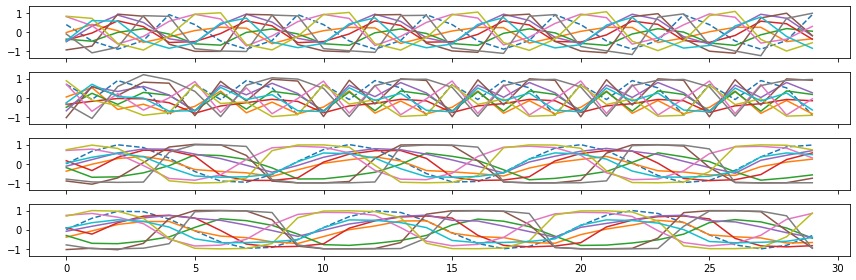

In [19]:
fig, ax = plt.subplots(len(ut), 1, figsize=(12, len(ut)), sharex=True, sharey=True)
for i in range(len(ut)):
    ax[i].plot(ut[i][:30], ls='--')
    ax[i].plot(xt_conceptor[i][:30][:,1:10])
plt.tight_layout()

# full_procedure (in one step using trainingConfig)

In [20]:
prng = np.random.default_rng(1234)

In [21]:
trainingConfig = config.TrainingConfig(
    washout=200,
    aperture=100,
    w_regularizer=1e-3,
    wout_regularizer=1e-3
)

In [22]:
esnConfig = config.ESNConfig(
    input_size=1,
    reservoir_size=100,
    output_size=1,
    feedback=False,
    spectral_radius=1,
    init_weights='normal',
    init_weights_b='normal',
    init_weights_in='normal',
    init_weights_density=0.1,
    init_weights_in_density=1.0,
    init_weights__args={'loc': 0., 'scale': 1.},
    init_weights_b__args={'loc': 0., 'scale': 0.2},
    init_weights_in__args={'loc': 0., 'scale': 1.},
)

In [23]:
T_pattern = 2500
ut = [
    helper.n_periodic(5, T_pattern, np.random.default_rng(27)),
    helper.n_periodic(5, T_pattern, np.random.default_rng(42)),
    helper.n_sine(8.83, T_pattern, phase=0.),
    helper.n_sine(9.83, T_pattern, phase=0.)
]

In [24]:
esn = ESN(esnConfig, prng)

In [25]:
Ci = esn.full_procedure(ut, trainingConfig)

In [26]:
ut_zero = np.zeros_like(ut[0])
x_init = prng.uniform(low=-1., high=1., size=(esn.reservoir_size, 1))
xt_conceptor, yt_conceptor = list(zip(*[
    esn.harvest_states(ut_zero.copy(), x_init=x_init.copy(), C=Ci[i])
    for i in range(len(ut))
]))

In [27]:
_,l=helper.testLRMSE(ut, yt_conceptor, 12)

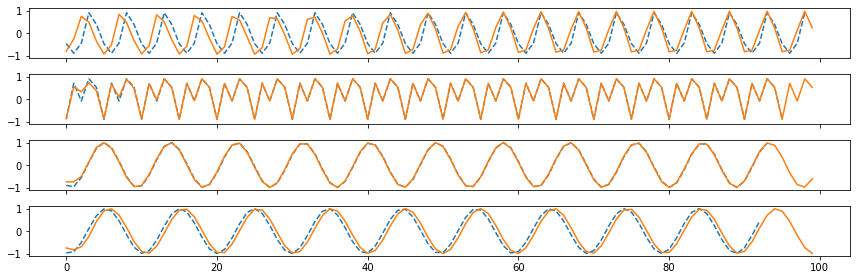

In [28]:
fig, ax = plt.subplots(len(ut), 1, figsize=(12, len(ut)), sharex=True, sharey=True)
for i in range(len(ut)):
    ax[i].plot(ut[i][l[i]:100], ls='--')
    ax[i].plot(yt_conceptor[i][:100])
plt.tight_layout()

# Hyperparameters search